In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision.models as models
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from tqdm import trange

first part : classification with pretrained model weights and modified fully connected layer

In [2]:
# building the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50 = models.resnet50(pretrained=True)
resnet50.fc = nn.Identity()

for params in resnet50.parameters():
    params.requires_grad = True

class pretrained_classifier(nn.Module):
    def __init__ (self):
        super(pretrained_classifier, self).__init__()
        self.resnet = resnet50
        self.fc = nn.Linear(2048, 2)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = self.resnet(x)
        x = self.fc(x)
        x = self.softmax(x)
        return x

model = pretrained_classifier().to(device)


c:\Users\lesol\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lesol\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified


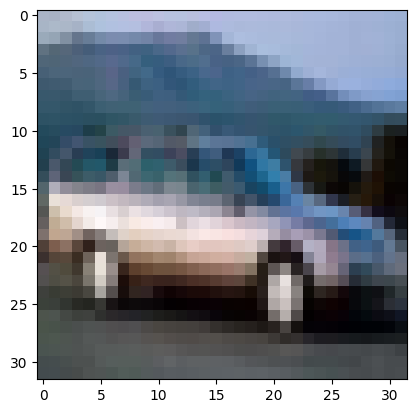

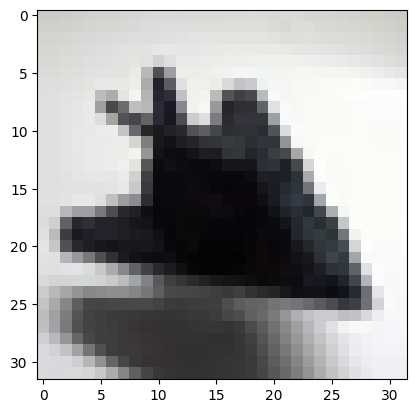

In [3]:
# preparing the data

cifar10_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True)
cifar10_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True)
  
train_data = []
train_label = []
test_data = []
test_label = []

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

for i in range(len(cifar10_train_dataset)):
    if cifar10_train_dataset[i][1] == 0 or cifar10_train_dataset[i][1] == 1:
        train_data.append(cifar10_train_dataset[i][0])
        train_label.append(cifar10_train_dataset[i][1])

for i in range(len(cifar10_test_dataset)):
    if cifar10_test_dataset[i][1] == 0 or cifar10_test_dataset[i][1] == 1:
        test_data.append(cifar10_test_dataset[i][0])
        test_label.append(cifar10_test_dataset[i][1])

plt.imshow(train_data[0])
plt.show()
plt.imshow(train_data[2])
plt.show()

for i in range(len(train_data)):
    train_data[i] = transform(train_data[i])
for i in range(len(test_data)):
    test_data[i] = transform(test_data[i])

train_data = torch.stack(train_data)
test_data = torch.stack(test_data)

train_dataset = TensorDataset(train_data, torch.tensor(train_label))
test_dataset = TensorDataset(test_data, torch.tensor(test_label))

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)



100%|██████████| 30/30 [01:33<00:00,  3.12s/it]


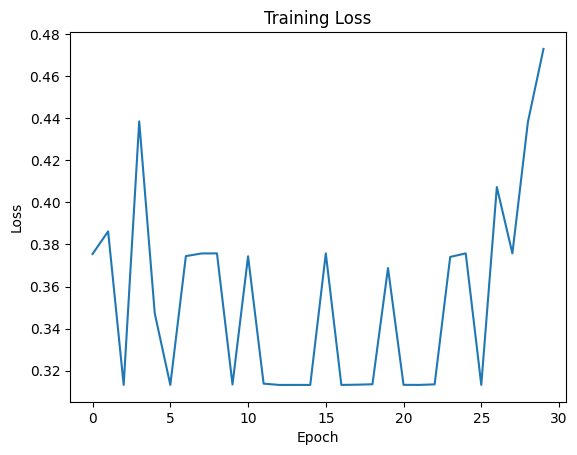

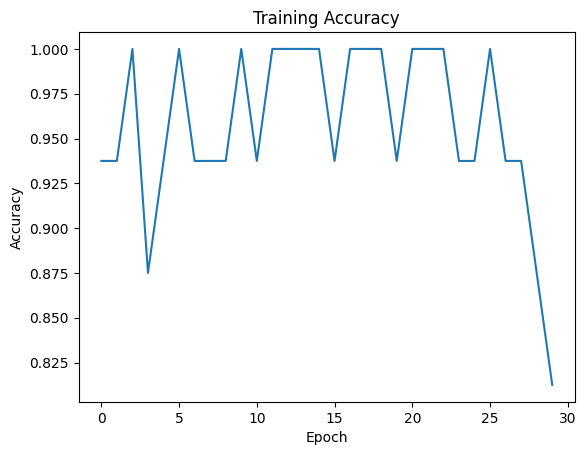

In [4]:
# training loop

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001)

num_epoch = 30
train_loss = []
train_accuracy = []
for i in trange(num_epoch):
    for j, (data, label) in enumerate(train_loader) :
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
    train_loss.append(loss.item())
    train_accuracy.append(accuracy_score(label.cpu(), torch.argmax(output, dim=1).cpu()))
        
        
plt.plot(train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

plt.plot(train_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show()

In [5]:
# test
prediction = []
target = []
model.eval()
with torch.no_grad():
    for i, (data, label) in enumerate(test_loader) :
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        prediction += torch.argmax(output, dim=1).cpu().tolist()
        target += label.cpu().tolist()

print("first part accuracy: " + str(accuracy_score(target, prediction)))

first part accuracy: 0.961


second part : training the feature extracor on triplet loss independent fo fully connected layer

we have to define a new dataset class because we need to have anchor, positive data and negative data for triplet loss

In [6]:
class custom_dataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    def __getitem__(self, index):
        anchor = self.dataset[index][0]
        anchor_label = self.dataset[index][1]
        positive_index = index
        while positive_index == index or self.dataset[positive_index][1] != anchor_label:
            positive_index = torch.randint(0, len(self.dataset), (1,)).item()
        positive = self.dataset[positive_index][0]
        positive_label = self.dataset[positive_index][1]
        negative_index = index
        while negative_index == index or self.dataset[negative_index][1] == anchor_label:
            negative_index = torch.randint(0, len(self.dataset), (1,)).item()
        negative = self.dataset[negative_index][0]
        negative_label = self.dataset[negative_index][1]
        return anchor, anchor_label, positive, positive_label, negative, negative_label
    def __len__(self):
        return len(self.dataset)

c:\Users\lesol\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lesol\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 30/30 [04:12<00:00,  8.42s/it]


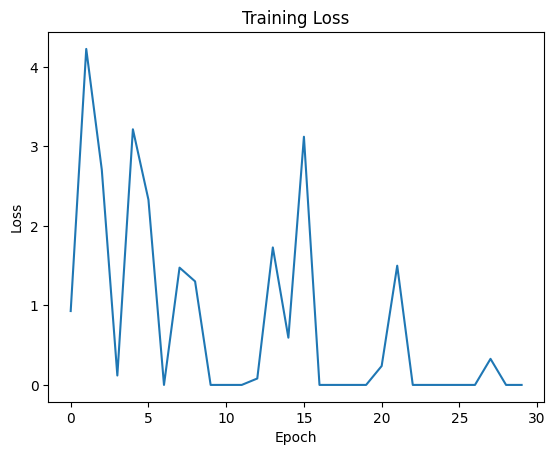

In [7]:
# training loop

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50 = models.resnet50(pretrained=True)

resnet50.fc = nn.Identity()
resnet50 = resnet50.to(device)
for params in resnet50.parameters():
    params.requires_grad = True

criterion =  nn.TripletMarginLoss(margin=10, p=2)
optimizer = optim.Adam(resnet50.parameters(), lr= 0.003)
train_loader = DataLoader(custom_dataset(train_dataset), batch_size=256, shuffle=True)

num_epoch = 30
train_loss = []
for i in trange(num_epoch):
    for j, (anchor, anchor_label, positive, positive_label, negative, negative_label) in enumerate(train_loader) :
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)

        optimizer.zero_grad()
        anchor_output = resnet50(anchor)
        positive_output = resnet50(positive)
        negative_output = resnet50(negative)
        loss = criterion(anchor_output, positive_output, negative_output)

        loss.backward()
        optimizer.step()
    train_loss.append(loss.item())
        
        
plt.plot(train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [8]:
# adding a fully connected layer to our newly trained resnet

for params in resnet50.parameters():
    params.requires_grad = False
    
class pretrained_classifier(nn.Module):
    def __init__ (self):
        super(pretrained_classifier, self).__init__()
        self.resnet = resnet50
        self.fc = nn.Linear(2048, 2)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = self.resnet(x)
        x = self.fc(x)
        x = self.softmax(x)
        return x

model = pretrained_classifier().to(device)

100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


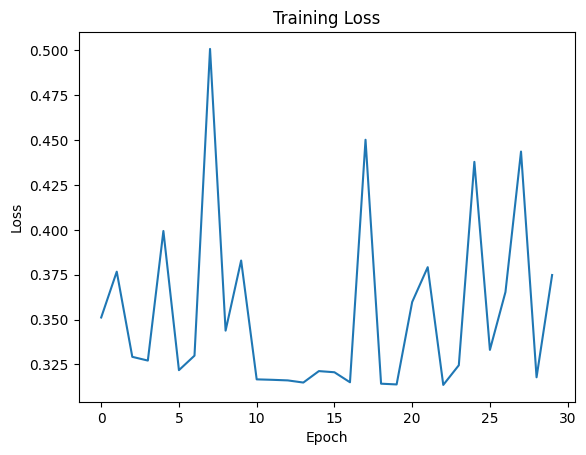

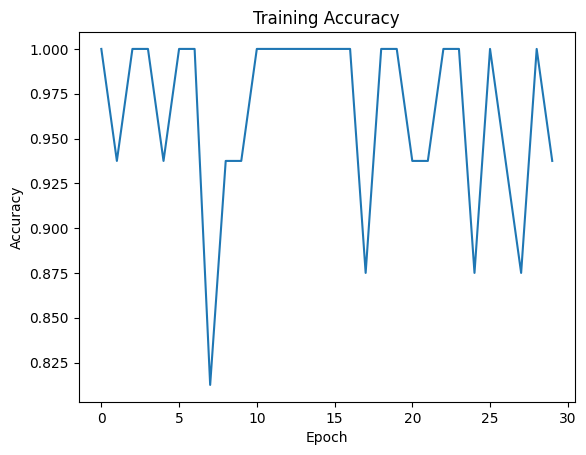

In [9]:
# training loop
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001)

num_epoch = 30
train_loss = []
train_accuracy = []
for i in trange(num_epoch):
    for j, (data, label) in enumerate(train_loader) :
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
    train_loss.append(loss.item())
    train_accuracy.append(accuracy_score(label.cpu(), torch.argmax(output, dim=1).cpu()))
        
        
plt.plot(train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

plt.plot(train_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show()

In [10]:
# test

prediction = []
target = []
model.eval()
with torch.no_grad():
    for i, (data, label) in enumerate(test_loader) :
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        prediction += torch.argmax(output, dim=1).cpu().tolist()
        target += label.cpu().tolist()

print("second part accuracy: " + str(accuracy_score(target, prediction)))

second part accuracy: 0.9715


third part : we train resnet and fully connected simultainously

c:\Users\lesol\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lesol\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 30/30 [04:10<00:00,  8.36s/it]


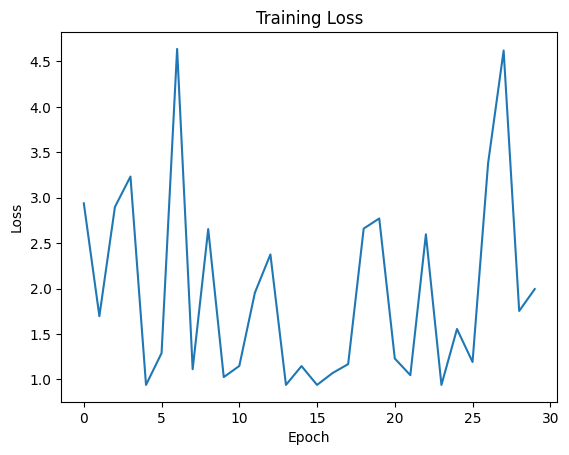

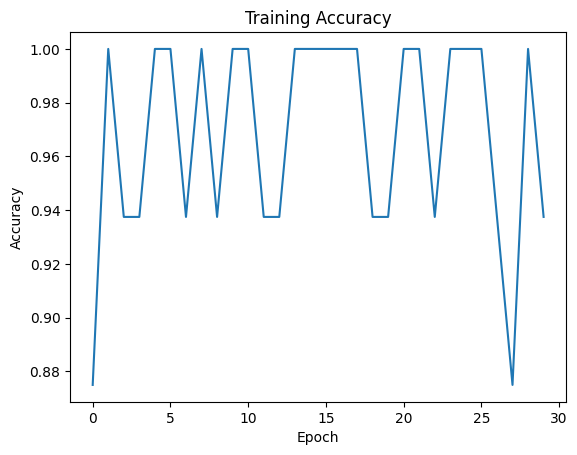

In [11]:
resnet50 = models.resnet50(pretrained=True)
resnet50.fc = nn.Identity()

for params in resnet50.parameters():
    params.requires_grad = True

class pretrained_classifier(nn.Module):
    def __init__ (self):
        super(pretrained_classifier, self).__init__()
        self.resnet = resnet50
        self.fc = nn.Linear(2048, 2)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        features    = self.resnet(x)
        x           = self.fc(features)
        x           = self.softmax(x)
        return features, x

model = pretrained_classifier().to(device)

criterion1 =  nn.TripletMarginLoss(margin=10, p=2)
criterion2 = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.003)
train_loader = DataLoader(custom_dataset(train_dataset), batch_size=256, shuffle=True)

num_epoch = 30
train_loss = []
train_accuracy = []
for i in trange(num_epoch):
    for j, (anchor, anchor_label, positive, positive_label, negative, negative_label) in enumerate(train_loader) :
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)
        anchor_label = anchor_label.to(device)
        positive_label = positive_label.to(device)
        negative_label = negative_label.to(device)

        optimizer.zero_grad()
        anchor_output_feature, anchor_output        = model(anchor)
        positive_output_feature, positive_output    = model(positive)
        negative_output_feature, negative_output    = model(negative)
        loss = criterion1(anchor_output_feature, positive_output_feature, negative_output_feature) + criterion2(anchor_output, anchor_label) + criterion2(positive_output, positive_label) + criterion2(negative_output, negative_label)

        loss.backward()
        optimizer.step()
    train_loss.append(loss.item())
    train_accuracy.append(accuracy_score(anchor_label.cpu(), torch.argmax(anchor_output, dim=1).cpu()))
        
        
plt.plot(train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

plt.plot(train_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show()

In [12]:
prediction = []
target = []
model.eval()
with torch.no_grad():
    for i, (data, label) in enumerate(test_loader) :
        data = data.to(device)
        label = label.to(device)
        _,output = model(data)
        prediction += torch.argmax(output, dim=1).cpu().tolist()
        target += label.cpu().tolist()

print("third part accuracy: " + str(accuracy_score(target, prediction)))

third part accuracy: 0.967


conclusion :
training with triplet loss improves accuracy over standard training with cross entropy loss, 

as for the second part and the third part, because the fc layer is learning along the resnet layer,

the acccracy decreases a little compared to when the feature extractor is trained fully with triplet loss